# Data Prep

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("test.csv")

In [3]:
train_df

,filename,diagnostic
0,PAD-UFES-20/PAT_735_1391_683.png,ACK
1,PAD-UFES-20/PAT_1722_3214_672.png,ACK
2,PAD-UFES-20/PAT_730_1385_585.png,BCC
3,PAD-UFES-20/PAT_999_20_223.png,ACK
4,PAD-UFES-20/PAT_625_1184_994.png,SEK
...,...,...
1833,PAD-UFES-20/PAT_718_1358_919.png,BCC
1834,PAD-UFES-20/PAT_2153_4782_321.png,ACK
1835,PAD-UFES-20/PAT_930_1760_560.png,BCC
1836,PAD-UFES-20/PAT_652_1231_516.png,BCC


In [4]:
val_df

,filename,diagnostic
0,PAD-UFES-20/PAT_967_1827_247.png,BCC
1,PAD-UFES-20/PAT_905_1721_327.png,BCC
2,PAD-UFES-20/PAT_1661_2956_357.png,ACK
3,PAD-UFES-20/PAT_1107_427_352.png,NEV
4,PAD-UFES-20/PAT_2077_4463_77.png,ACK
...,...,...
455,PAD-UFES-20/PAT_1922_3848_451.png,SEK
456,PAD-UFES-20/PAT_1468_3656_337.png,ACK
457,PAD-UFES-20/PAT_406_809_581.png,BCC
458,PAD-UFES-20/PAT_1573_2497_736.png,ACK


In [5]:
BATCH_SIZE = 4
IMG_SIZE = 224
NUM_CLASSES = train_df["diagnostic"].nunique()
TRAIN_RATIO = 0.8

In [6]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    val_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1838 validated image filenames belonging to 6 classes.
Found 460 validated image filenames belonging to 6 classes.


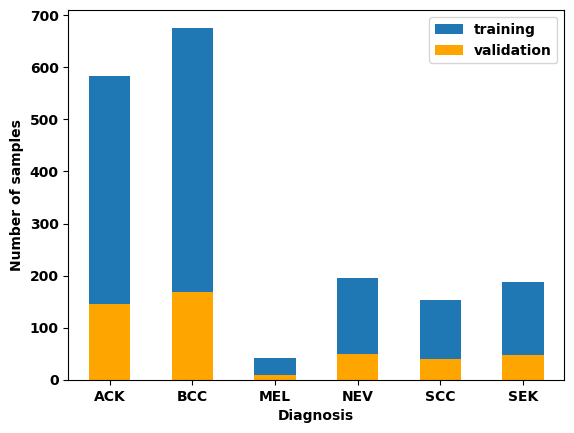

In [7]:
# plt.hist(training_generator.labels)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
train_df.diagnostic.value_counts().sort_index().plot.bar(label="training")
val_df.diagnostic.value_counts().sort_index().plot.bar(label="validation", color="orange")
plt.xlabel("Diagnosis")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.legend()
plt.show()

In [8]:
train_df.diagnostic.value_counts().sort_index()

ACK    584
BCC    676
MEL     42
NEV    195
SCC    153
SEK    188
Name: diagnostic, dtype: int64

(array([146.,   0., 169.,   0.,  10.,   0.,  49.,   0.,  39.,  47.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

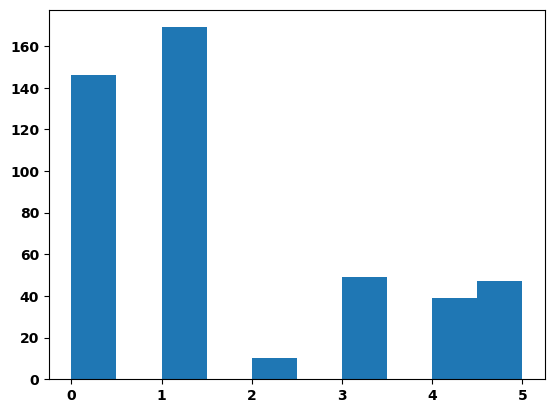

In [9]:
plt.hist(val_generator.labels)

In [10]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 0.5245433789954338,
 1: 0.4531558185404339,
 2: 7.2936507936507935,
 3: 1.570940170940171,
 4: 2.002178649237473,
 5: 1.6294326241134751}

In [11]:
classes = train_df["diagnostic"].unique()

# Train Teacher branch - DenseNet

In [12]:
from tensorflow.keras.applications.densenet import DenseNet121

In [13]:
def build_DenseNet_model():

    backbone_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    classifier = tf.keras.layers.Dense(units = NUM_CLASSES, activation = 'softmax')(leaky_relu)
    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    
    # Added to improve gradcam output
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ZeroPadding2D):
            continue
        layer.padding = "same"
            
    return model

In [14]:
teacher_model = build_DenseNet_model()

In [15]:
teacher_model.load_weights("models_normal/Teacher/160_1.021_0.691.h5")

In [ ]:
EPOCHS = 100

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_dense_lessfc_gradcam/Global/best_model.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
history = teacher_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
    class_weight=class_weights
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = teacher_model.evaluate(val_generator)
print(val_loss, val_accuracy)

In [ ]:
global_model.save_weights(f"models_mips/Global/190_{val_loss:.3f}_{val_accuracy:.3f}.h5")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred_all = []
y_test_all = []
labels = list(val_generator.class_indices.keys())
print(labels)

STEPS_PER_EPOCH = val_generator.samples//BATCH_SIZE
for i in range(STEPS_PER_EPOCH):
    print(f"\r{i}/{STEPS_PER_EPOCH}", end = "")
    x, y_test = val_generator.next()
    y_pred = global_model(x, training=False)
    for y in y_test:
        y_test_all.append(tf.argmax(y))
        
    for y in y_pred:
        y_pred_all.append(tf.argmax(y))
        
cm = confusion_matrix(y_test_all, y_pred_all)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Initialize student model - MobileNet

In [16]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [17]:
def build_Mobilenet_model():
    backbone_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    classifier = tf.keras.layers.Dense(units = NUM_CLASSES, activation = 'softmax')(leaky_relu)
    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    
    # Added to improve gradcam output
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ZeroPadding2D):
            continue
        layer.padding = "same"
            
    return model

In [18]:
class Distiller(tf.keras.Model):
    def __init__(self, student):
        super().__init__()
#         self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        
    def train_step(self, data):
        # Unpack data
        # Ignoring sample weights here (consider later if possible)
        x, y, sample_weights = data        

        # Forward pass of teacher
        teacher_predictions = teacher_model(x, training=False) # Using the global teacher variable

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [19]:
student_model = build_Mobilenet_model()

In [20]:
distiller = Distiller(student=student_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
)

In [25]:
distiller.load_weights("models_normal/Student/54_1.018_0.654.h5")

In [22]:
EPOCHS = 100

In [23]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_normal/Student/{epoch:02d}_{val_student_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1, 
                             mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]
mycallbacks = [learning_rate_reduction,checkpoint]

In [24]:
history = distiller.fit_generator(
    training_generator,
#     steps_per_epoch=1,
#     validation_steps=1,
    epochs = EPOCHS,
#     initial_epoch=47,
    validation_data = val_generator,
    callbacks = mycallbacks,
    class_weight=class_weights
)

C:\Users\vaash\AppData\Local\Temp\ipykernel_26984\885848570.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = distiller.fit_generator(
C:\Users\vaash\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
  3/460 [..............................] - ETA: 2:26 - accuracy: 0.0833 - student_loss: 2.6283 - distillation_loss: 0.0911 

KeyboardInterrupt: 

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = distiller.evaluate(val_generator)
print(val_loss, val_accuracy)

# Visualize and Save attention maps

In [ ]:
training_generator.class_indices

In [ ]:
images, labels = training_generator.next()

In [ ]:
%%time
heatmaps = get_featuremaps(images, distiller.student)

In [ ]:
overlaid_images = [overlay_heatmap(hmap.numpy(), img, alpha=0.8) for (hmap, img) in zip(heatmaps, images)]

In [ ]:
print("True labels: ", tf.argmax(labels, axis = 1).numpy())
print("Predictions: ", tf.argmax(teacher_model(images), axis=1).numpy())

In [ ]:
plt.imshow(np.hstack(images))

In [ ]:
plt.imshow(np.hstack(heatmaps), cmap="jet")

In [ ]:
plt.imshow(np.hstack(overlaid_images))

In [ ]:
OUTPUT_FOLDER = "MIPS_teacher"
!mkdir "$OUTPUT_FOLDER"

In [ ]:
IMAGE_START = 8

In [ ]:
!mkdir "$OUTPUT_FOLDER/images"
for img_id, (img, label) in enumerate(zip(images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/images/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/gradcams"
for img_id, (img, label) in enumerate(zip(heatmaps, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/gradcams/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/overlaid"
for img_id, (img, label) in enumerate(zip(overlaid_images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/overlaid/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

# Metrics

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score, classification_report

In [27]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred_batch/= tf.reshape(
            tf.reduce_sum(y_pred_batch, axis=1), 
            (-1, 1)
        )
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    precision = precision_score(y_true, y_pred_max, average="weighted")
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average="weighted")
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average="weighted")
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred, average="weighted", multi_class='ovr')
    print("AUC: ", auc)
#     return y_true, y_pred
    return classification_report(y_true, y_pred_max, digits=5)

In [28]:
def pred_student(images, labels):
    return distiller.student(images, training=False)

In [29]:
class_report_distilled = get_metrics(pred_student)
print(class_report_distilled)

114/115
Accuracy:  0.6543478260869565
Precision:  0.6686328218799928
Recall:  0.6543478260869565
F1:  0.6508221110155401
AUC:  0.8894520204466724
              precision    recall  f1-score   support

           0    0.69143   0.82877   0.75389       146
           1    0.77778   0.57988   0.66441       169
           2    0.70000   0.70000   0.70000        10
           3    0.53425   0.79592   0.63934        49
           4    0.31579   0.30769   0.31169        39
           5    0.63158   0.51064   0.56471        47

    accuracy                        0.65435       460
   macro avg    0.60847   0.62048   0.60567       460
weighted avg    0.66863   0.65435   0.65082       460

